This notebook  is about predictions for time-series, based on the Kaggle challenge "Future Sales"
https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview .
The AR, MA analysis is based on Jagan's kernel https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts, the LSTM part is inspired by https://www.kaggle.com/karanjakhar/simple-and-easy-aprroach-using-lstm .

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import time
import os

In [2]:
train_df = pd.read_csv('sales_train.csv')
test_df = pd.read_csv('test.csv').drop('ID', axis=1)

items_df = pd.read_csv('items.csv')
item_cat_df = pd.read_csv('item_categories.csv')
shops_df = pd.read_csv('shops.csv')

In [3]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [5]:
item_cat_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [3]:
import datetime # manipulating date formats

#formatting the date column correctly
train_df.date=train_df.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [8]:
train_df.date[0]

Timestamp('2013-01-02 00:00:00')

In [4]:
monthly_sales = train_df.groupby(['date_block_num','shop_id','item_id'])[
    'date','item_price','item_cnt_day'].agg({'date':['min','max'], 'item_price':'mean', 'item_cnt_day':'sum'})

# Aggregate by date-block(month),shop_id and item_id
# select the columns date,item_price and item_cnt(sales)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the item_price
# sum of the sales

In [10]:
monthly_sales.head(10)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0

In [11]:
# number of item per category

x = items_df.groupby(['item_category_id']).count()
x = x.sort_values('item_id', ascending=False)
x=x.iloc[0:10].reset_index()
x

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
5,30,756,756
6,72,666,666
7,19,628,628
8,61,598,598
9,23,501,501


/Users/Benjamin/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


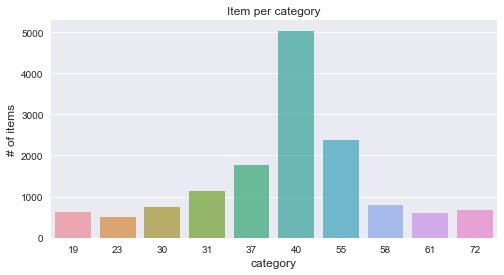

In [12]:
plt.figure(figsize=(8,4))
ax = sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title('Item per category')
plt.xlabel('category', fontsize=12)
plt.ylabel('# of items', fontsize=12);

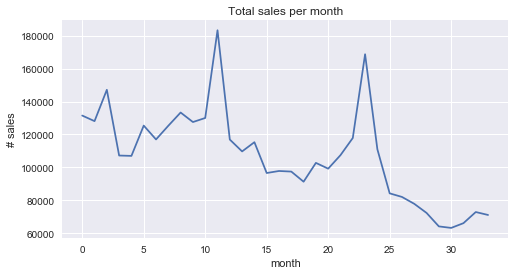

In [6]:
# total sales per month

ts = train_df.groupby(['date_block_num'])['item_cnt_day'].sum()

plt.figure(figsize=(8,4))
plt.plot(ts)
plt.title('Total sales per month')
plt.xlabel('month')
plt.ylabel('# sales');

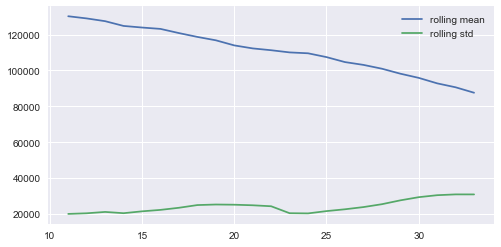

In [7]:
plt.figure(figsize=(8,4))
plt.plot(ts.rolling(window=12,center=False).mean(), label='rolling mean')
plt.plot(ts.rolling(window=12,center=False).std(), label='rolling std')
plt.legend();

Quick observations: There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".  
Let's see that with some proper tools.

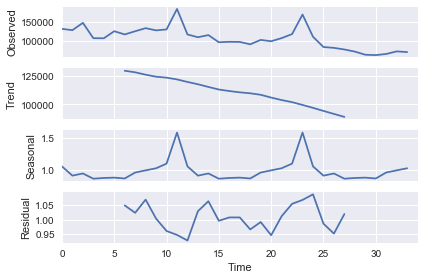

In [8]:
import statsmodels.api as sm

# Multipicative model: y(t) = S(t) x T(t) x R(t)
res = sm.tsa.seasonal_decompose(ts.values, freq=12, model='multiplicative')
# plt.figure(figsize=(8,4))
fig = res.plot()
# fig.show()

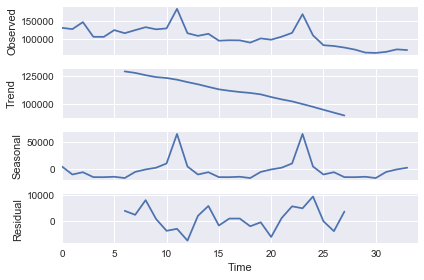

In [9]:
# Additive model: y(t) = S(t) + T(t) + E(t)
res = sm.tsa.seasonal_decompose(ts.values, freq=12, model='additive')
# plt.figure(figsize=(8,4))
fig = res.plot()
# fig.show()

### Stationnarity

In [10]:
# Stationarity tests
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [111]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced forecast
def inv_difference(diff_ts, interval, first_obs):
    assert len(first_obs) == interval
    diff_ts_list = list(diff_ts)
    ts = list(first_obs)
    for i in range(len(diff_ts_list)):
        value = 0
        j=0
        while i - j*interval >=0:
            value += diff_ts_list[i-j*interval]
            j +=1
        value += list(first_obs)[i-j*interval]
        ts.append(value)
    return pd.Series(ts)

In [113]:
ts_0 = pd.Series([1,4,6,7,9])
diff_ts_0 = difference(ts_0,2)
print(diff_ts_0)
print(inv_difference(diff_ts_0,2,ts_0[:2]))

0    5
1    3
2    3
dtype: int64
0    1
1    4
2    6
3    7
4    9
dtype: int64


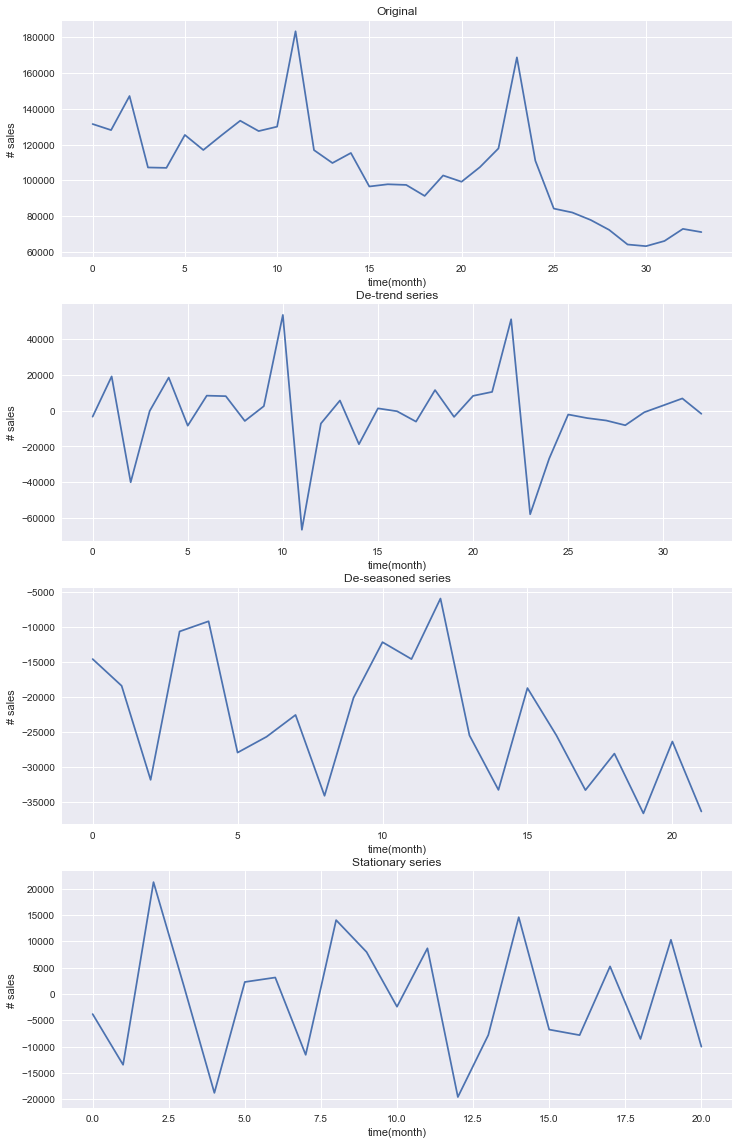

In [31]:
ts = train_df.groupby(['date_block_num'])['item_cnt_day'].sum()
ts.astype('float')
ts_no_trend = difference(ts)
ts_no_season = difference(ts, interval=12) # assuming the seasonality is 12 months long
ts_station = difference(ts_no_trend, interval=12)


plt.figure(figsize=(12,20))

plt.subplot(411)
plt.plot(ts)
plt.title('Original')
plt.xlabel('time(month)')
plt.ylabel('# sales')

plt.subplot(412)
plt.plot(ts_no_trend)
plt.title('De-trend series')
plt.xlabel('time(month)')
plt.ylabel('# sales')

plt.subplot(413)
plt.plot(ts_no_season) 
plt.title('De-seasoned series')
plt.xlabel('time(month)')
plt.ylabel('# sales');

plt.subplot(414)
plt.plot(ts_station) 
plt.title('Stationary series')
plt.xlabel('time(month)')
plt.ylabel('# sales');

In [32]:
# now testing the stationarity again
test_stationarity(ts_no_trend)

Results of Dickey-Fuller Test:
Test Statistic                -1.363622e+01
p-value                        1.686395e-25
#Lags Used                     1.000000e+01
Number of Observations Used    2.200000e+01
Critical Value (1%)           -3.769733e+00
Critical Value (5%)           -3.005426e+00
Critical Value (10%)          -2.642501e+00
dtype: float64


In [33]:
test_stationarity(ts_no_season)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [34]:
test_stationarity(ts_station)

Results of Dickey-Fuller Test:
Test Statistic                -6.002134e+00
p-value                        1.647765e-07
#Lags Used                     0.000000e+00
Number of Observations Used    2.000000e+01
Critical Value (1%)           -3.809209e+00
Critical Value (5%)           -3.021645e+00
Critical Value (10%)          -2.650713e+00
dtype: float64


## AR, MA and ARMA models:

The following is about determining the AR and MA orders of the time-series.

In [14]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

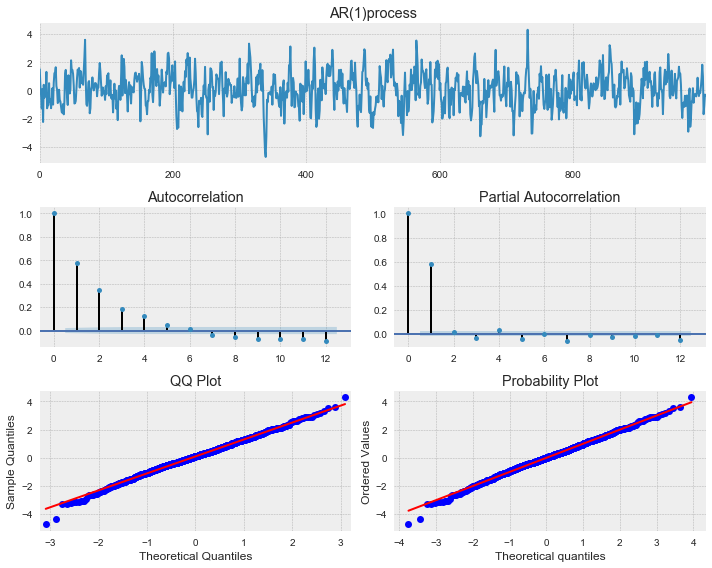

In [15]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

AR(1) process -- has ACF tailing out and PACF cutting off at lag=1

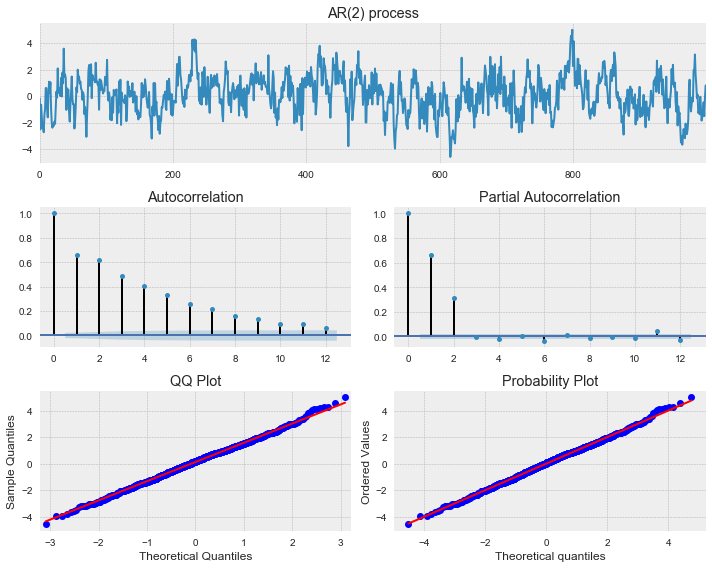

In [16]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

AR(2) process -- has ACF tailing out and PACF cutting off at lag=2

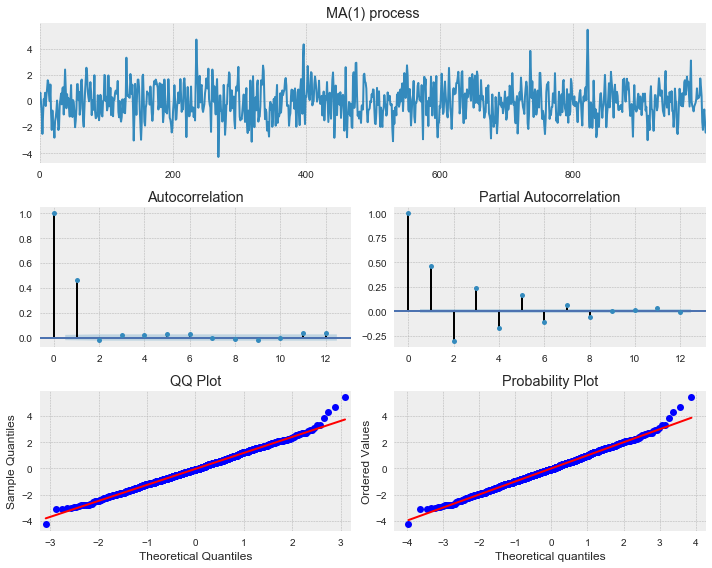

In [17]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

MA(1) process -- has ACF cut off at lag=1

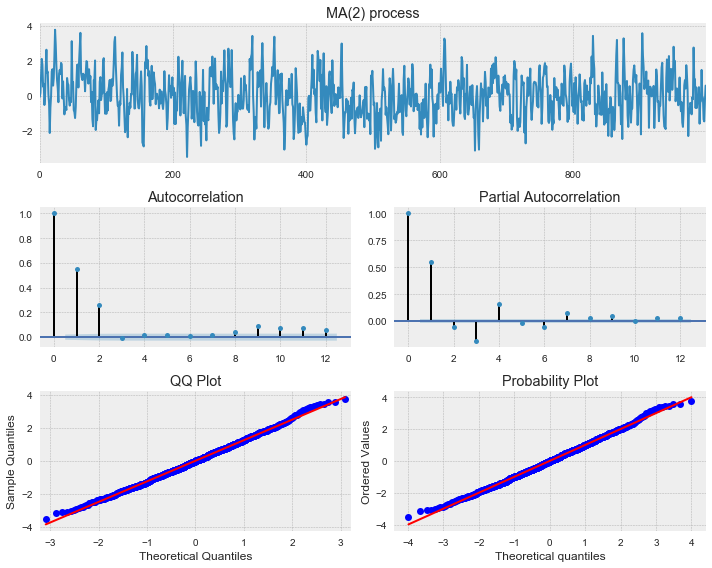

In [18]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

MA(2) process -- has ACF cut off at lag=2

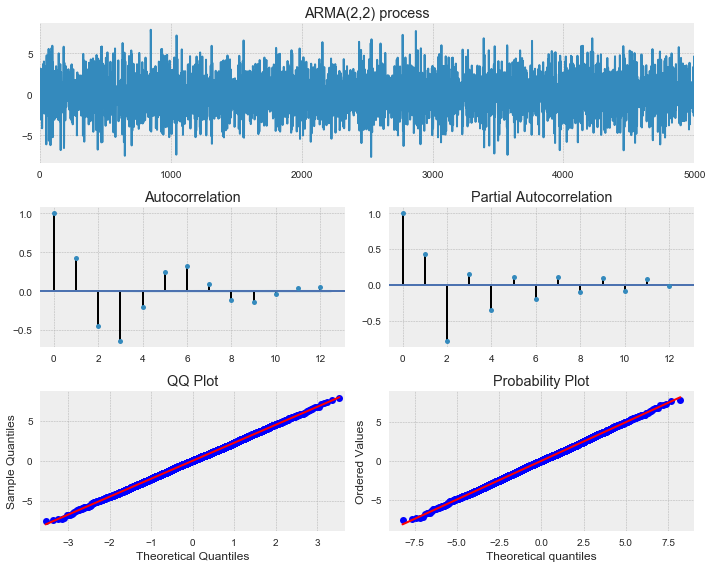

In [19]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

Let's use a systematic approach to finding the order of AR and MA processes.

In [20]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 15326.68109 | order: (2, 2)


We've correctly identified the order of the simulated process as ARMA(2,2).  
Lets use it for the sales time-series (no_season ts).

In [177]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
second_best_aic = np.inf 
best_order = None
second_best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(ts_station.values, order=(i, j)).fit(method='mle', trend='nc')
            if tmp_mdl.aic < best_aic:
                second_best_aic = best_aic
                second_best_order = best_order
                best_aic = tmp_mdl.aic
                best_order = (i, j)
                best_mdl = tmp_mdl
            elif tmp_mdl.aic < second_best_aic:
                second_best_aic = tmp_mdl.aic
                second_best_order = (i,j)
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
print('second_aic: {:6.5f} | order: {}'.format(second_best_aic, second_best_order))

aic: 447.91852 | order: (0, 1)
second_aic: 448.25296 | order: (2, 1)


/Users/Benjamin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


### Using ARIMA model from statsmodels.tsa

(the case here is a little too basic for a good illustration)

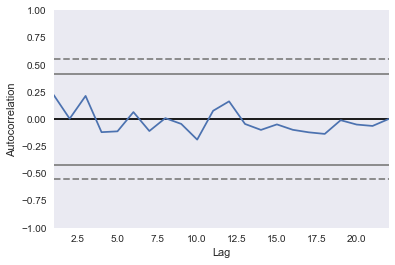

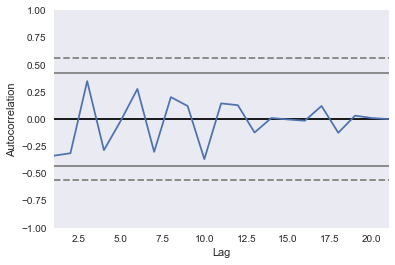

In [128]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(ts_no_season)
plt.show()
autocorrelation_plot(ts_station)
plt.show()

In [92]:
from statsmodels.tsa.arima_model import ARIMA

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   21
Model:                     ARMA(2, 1)   Log Likelihood                -219.900
Method:                       css-mle   S.D. of innovations           8255.865
Date:                Mon, 30 Sep 2019   AIC                            449.801
Time:                        11:15:59   BIC                            455.024
Sample:                             0   HQIC                           450.934
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -787.7785   1167.443     -0.675      0.509   -3075.925    1500.368
ar.L1.y       -0.9154      0.211     -4.328      0.000      -1.330      -0.501
ar.L2.y       -0.6851      0.168     -4.088      0.0

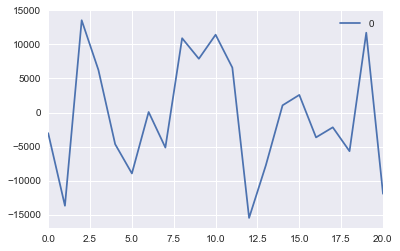

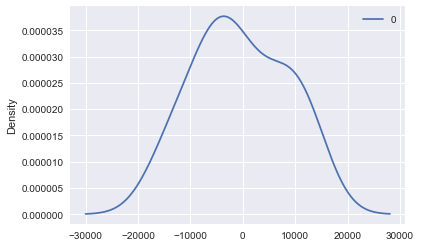

                  0
count     21.000000
mean    -480.500454
std     8766.913107
min   -15484.879620
25%    -5680.307492
50%    -2175.597081
75%     6597.763682
max    13557.442448


In [178]:
# fit model
model = ARIMA(ts_station, order=(2,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [179]:
# Predictions for total future sales
num_pred = 6
pred_station = model_fit.predict(start=21, end=21+num_pred)
pred_no_trend = inv_difference(pred_station, 12, ts_no_trend[-12:])
pred = inv_difference(pred_no_trend, 1, ts[-1:])

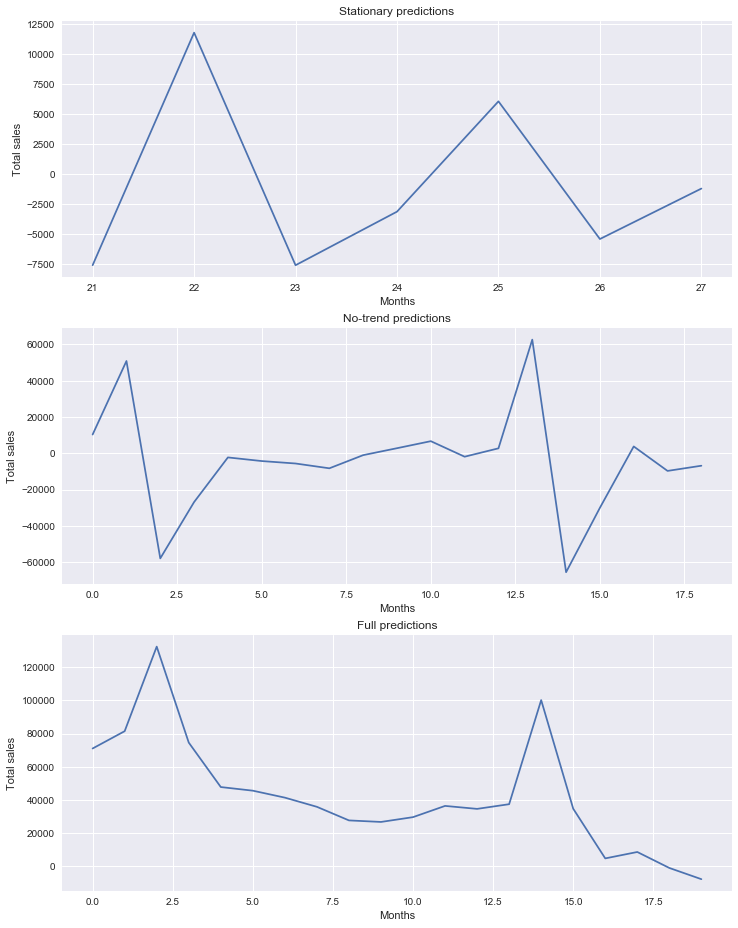

In [180]:
plt.figure(figsize=(12,16))

plt.subplot(311)
plt.plot(pred_station)
plt.title('Stationary predictions')
plt.xlabel('Months')
plt.ylabel('Total sales')

plt.subplot(312)
plt.plot(pred_no_trend)
plt.title('No-trend predictions')
plt.xlabel('Months')
plt.ylabel('Total sales')

plt.subplot(313)
plt.plot(pred)
plt.title('Full predictions')
plt.xlabel('Months')
plt.ylabel('Total sales');

## Prophet

In [ ]:
# Problem with installing fbprophet. Too bad!
!pip install fbprophet

In [98]:
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
ts.columns=['ds','y']
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

ModuleNotFoundError: No module named 'fbprophet'

## LSTM model

In [205]:
train_df = pd.read_csv('sales_train.csv')

In [206]:
#The 'date' column in sales_data is an object but if we want to manipulate 
#it we have convert it on datetime format
train_df['date'] = pd.to_datetime(train_df['date'], format = '%d.%m.%Y')

In [230]:
dataset = train_df.pivot_table(index = ['shop_id','item_id'], values = ['item_cnt_day'],
                                 columns = ['date_block_num'], fill_value = 0, aggfunc='sum')

In [208]:
dataset.head()

item_cnt_day                             ...                 \
date_block_num            0   1  2  3  4  5  6  7  8  9  ... 24 25 26 27 28   
shop_id item_id                                          ...                  
0       30                 0  31  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   
        31                 0  11  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   
        32                 6  10  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   
        33                 3   3  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   
        35                 1  14  0  0  0  0  0  0  0  0 ...  0  0  0  0  0   

                                
date_block_num  29 30 31 32 33  
shop_id item_id                 
0       30       0  0  0  0  0  
        31       0  0  0  0  0  
        32       0  0  0  0  0  
        33       0  0  0  0  0  
        35       0  0  0  0  0  

[5 rows x 34 columns]

In [231]:
dataset.reset_index(inplace = True)

In [232]:
dataset.head(10)
# 33 = number of months (= number of date_blocks)

shop_id item_id item_cnt_day                       ...        \
date_block_num                            0   1  2  3  4  5  6  7 ... 24 25   
0                    0      30            0  31  0  0  0  0  0  0 ...  0  0   
1                    0      31            0  11  0  0  0  0  0  0 ...  0  0   
2                    0      32            6  10  0  0  0  0  0  0 ...  0  0   
3                    0      33            3   3  0  0  0  0  0  0 ...  0  0   
4                    0      35            1  14  0  0  0  0  0  0 ...  0  0   
5                    0      36            0   1  0  0  0  0  0  0 ...  0  0   
6                    0      40            0   1  0  0  0  0  0  0 ...  0  0   
7                    0      42            0   1  0  0  0  0  0  0 ...  0  0   
8                    0      43            1   0  0  0  0  0  0  0 ...  0  0   
9                    0      49            0   2  0  0  0  0  0  0 ...  0  0   

                                        
date_block_num 26 27 28 29 30 31 32 33  
0               0  0  0  0  0  0  0  0  
1               0  0  0  0  0  0  0  0  
2               0  0  0  0  0  0  0  0  
3               0  0  0  0  0  0  0  0  
4               0  0  0  0  0  0  0  0  
5               0  0  0  0  0  0  0  0  
6               0  0  0  0  0  0  0  0  
7               0  0  0  0  0  0  0  0  
8               0  0  0  0  0  0  0  0  
9               0  0  0  0  0  0  0  0  

[10 rows x 36 columns]

In [213]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424124 entries, 0 to 424123
Data columns (total 36 columns):
(shop_id, )           424124 non-null int64
(item_id, )           424124 non-null int64
(item_cnt_day, 0)     424124 non-null int64
(item_cnt_day, 1)     424124 non-null int64
(item_cnt_day, 2)     424124 non-null int64
(item_cnt_day, 3)     424124 non-null int64
(item_cnt_day, 4)     424124 non-null int64
(item_cnt_day, 5)     424124 non-null int64
(item_cnt_day, 6)     424124 non-null int64
(item_cnt_day, 7)     424124 non-null int64
(item_cnt_day, 8)     424124 non-null int64
(item_cnt_day, 9)     424124 non-null int64
(item_cnt_day, 10)    424124 non-null int64
(item_cnt_day, 11)    424124 non-null int64
(item_cnt_day, 12)    424124 non-null int64
(item_cnt_day, 13)    424124 non-null int64
(item_cnt_day, 14)    424124 non-null int64
(item_cnt_day, 15)    424124 non-null int64
(item_cnt_day, 16)    424124 non-null int64
(item_cnt_day, 17)    424124 non-null int64
(item_cnt

In [162]:
test_df.head()

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [214]:
# keep only the shops_id and item_id of the test set.
dataset_small = pd.merge(test_df, dataset, on=['shop_id','item_id'], how='left')

/Users/Benjamin/anaconda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  
/Users/Benjamin/anaconda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:862: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  if len(self.left) > 0:


In [215]:
dataset_small.head()

,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [217]:
dataset_small.fillna(0,inplace = True)
dataset_small.head()

,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [218]:
dataset_small.drop(['shop_id','item_id'], axis=1, inplace=True)
dataset_small.head()

,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [220]:
# to train the model we take X to be all columns except the last one and y to be the last column.

X_train = np.expand_dims(dataset_small.values[:,:-1], axis=2)
y_train = dataset_small.values[:,-1]

print("Train shapes:",X_train.shape, y_train.shape)

# for X_test we keep all the columns except the first one (so that it has the same shape as X_train). 
# Then we will predict the sales for the week 34 (not in the table).
X_test = np.expand_dims(dataset_small.values[:,1:],axis = 2)

print("Test shapes:",X_test.shape)

Train shapes: (214200, 33, 1) (214200,)
Test shapes: (214200, 33, 1)


In [233]:
# 2nd try: Here we use instead the full training set to train the model.

dataset_test = pd.merge(test_df, dataset, on=['shop_id','item_id'], how='left')
dataset_test.fillna(0,inplace = True)
dataset_test.drop(['shop_id','item_id'], axis=1, inplace=True)

dataset.drop(['shop_id','item_id'], axis=1, inplace=True)

dataset.head()

/Users/Benjamin/anaconda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  
/Users/Benjamin/anaconda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:862: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  if len(self.left) > 0:
/Users/Benjamin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  import sys


item_cnt_day                             ...                    \
date_block_num           0   1  2  3  4  5  6  7  8  9  ... 24 25 26 27 28 29   
0                         0  31  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0   
1                         0  11  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0   
2                         6  10  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0   
3                         3   3  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0   
4                         1  14  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0   

                            
date_block_num 30 31 32 33  
0               0  0  0  0  
1               0  0  0  0  
2               0  0  0  0  
3               0  0  0  0  
4               0  0  0  0  

[5 rows x 34 columns]

In [234]:
X_train = np.expand_dims(dataset.values[:,:-1], axis=2)
y_train = dataset.values[:,-1]

print("Train shapes:",X_train.shape, y_train.shape)

X_test = np.expand_dims(dataset_test.values[:,1:],axis = 2)

print("Test shapes:",X_test.shape)

Train shapes: (424124, 33, 1) (424124,)
Test shapes: (214200, 33, 1)


### The model

In [170]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

Using TensorFlow backend.


In [237]:
lstm_out=32

In [238]:
lstm_model = Sequential()
lstm_model.add(LSTM(lstm_out, input_shape=X_train[0].shape))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(32))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

lstm_model.compile(loss="mse", optimizer="adam", metrics=['mean_squared_error'])

lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 32)                4352      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


In [239]:
lstm_model.fit(X_train, y_train, batch_size=1000, epochs=5)

Epoch 1/5
424124/424124 [==============================] - 41s 97us/step - loss: 15.7291 - mean_squared_error: 15.7291
Epoch 2/5
424124/424124 [==============================] - 38s 90us/step - loss: 15.2587 - mean_squared_error: 15.2587
Epoch 3/5
424124/424124 [==============================] - 41s 96us/step - loss: 15.1668 - mean_squared_error: 15.1668
Epoch 4/5
424124/424124 [==============================] - 41s 96us/step - loss: 15.0311 - mean_squared_error: 15.0311
Epoch 5/5
424124/424124 [==============================] - 38s 89us/step - loss: 15.2308 - mean_squared_error: 15.2308


### Submission

In [240]:
#submission_df = pd.read_csv('sample_submission.csv').drop('ID', axis=1)
submission_df = pd.read_csv('sample_submission.csv', index_col='ID')

In [241]:
submission_df.item_cnt_month = lstm_model.predict(X_test).clip(0,20)  # actual values are clipped to [0,20].
submission_df.head()

,item_cnt_month
ID,
0,0.350448
1,0.081692
2,0.734669
3,0.114296
4,0.081692


In [242]:
submission_df.to_csv('submission_lstm_2.csv')